# QBUS2820 Assignment 1

**SID:** 510575452

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Loading in Dataset

In [3]:
heating_load_training_data = pd.read_csv('data/HeatingLoad_training.csv')
heating_load_test_without_HL_data = pd.read_csv(
    'data/HeatingLoad_test_without_HL.csv')

# EDA

## Looking at key characteristics of the dataset

In [4]:
heating_load_training_data.head()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
0,18.56,30.36,1,13.75,453.67,3.89,0.65,275.89
1,13.82,9.64,0,18.70,138.85,0.95,0.55,208.02
2,36.47,8.44,1,18.23,190.31,4.71,0.56,234.86
3,23.23,18.71,1,21.89,313.15,8.51,0.25,243.89
4,11.62,11.95,0,19.49,117.53,1.57,0.58,205.94


In [5]:
heating_load_training_data.columns

Index(['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature',
       'SunlightExposure', 'WindSpeed', 'OccupancyRate', 'HeatingLoad'],
      dtype='object')

In [6]:
heating_load_training_data.shape

(10000, 8)

## Data Cleaning

### Removing null values

In [7]:
# drop nan values
heating_load_training_data = heating_load_training_data.dropna()


## Looking at the information of the dataset

In [8]:
heating_load_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BuildingAge         10000 non-null  float64
 1   BuildingHeight      10000 non-null  float64
 2   Insulation          10000 non-null  int64  
 3   AverageTemperature  10000 non-null  float64
 4   SunlightExposure    10000 non-null  float64
 5   WindSpeed           10000 non-null  float64
 6   OccupancyRate       10000 non-null  float64
 7   HeatingLoad         10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


## Looking at the description of the dataset

In [9]:
heating_load_training_data.describe().applymap('{:,.4f}'.format)

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,22.7655,20.7921,0.5960,18.0249,271.3616,4.4907,0.5001,260.0786
std,12.3860,16.8827,0.4907,4.0907,229.2752,2.5312,0.2220,74.5919
min,2.9900,3.0700,0.0000,1.6800,1.1500,0.0700,0.0100,173.6800
25%,14.2500,9.3100,0.0000,15.2700,100.0825,2.6100,0.3300,218.0875
50%,20.0900,15.0200,1.0000,18.0200,182.4350,4.1000,0.5000,236.8000
75%,28.0925,25.8300,1.0000,20.8100,407.0900,5.9600,0.6700,270.3500
max,153.8800,106.3600,1.0000,34.3400,"1,250.7100",18.9100,1.0000,793.9200


## Checking for null values

In [10]:
heating_load_training_data.isnull().sum()

BuildingAge           0
BuildingHeight        0
Insulation            0
AverageTemperature    0
SunlightExposure      0
WindSpeed             0
OccupancyRate         0
HeatingLoad           0
dtype: int64

## Check how each of the variables interact with each other

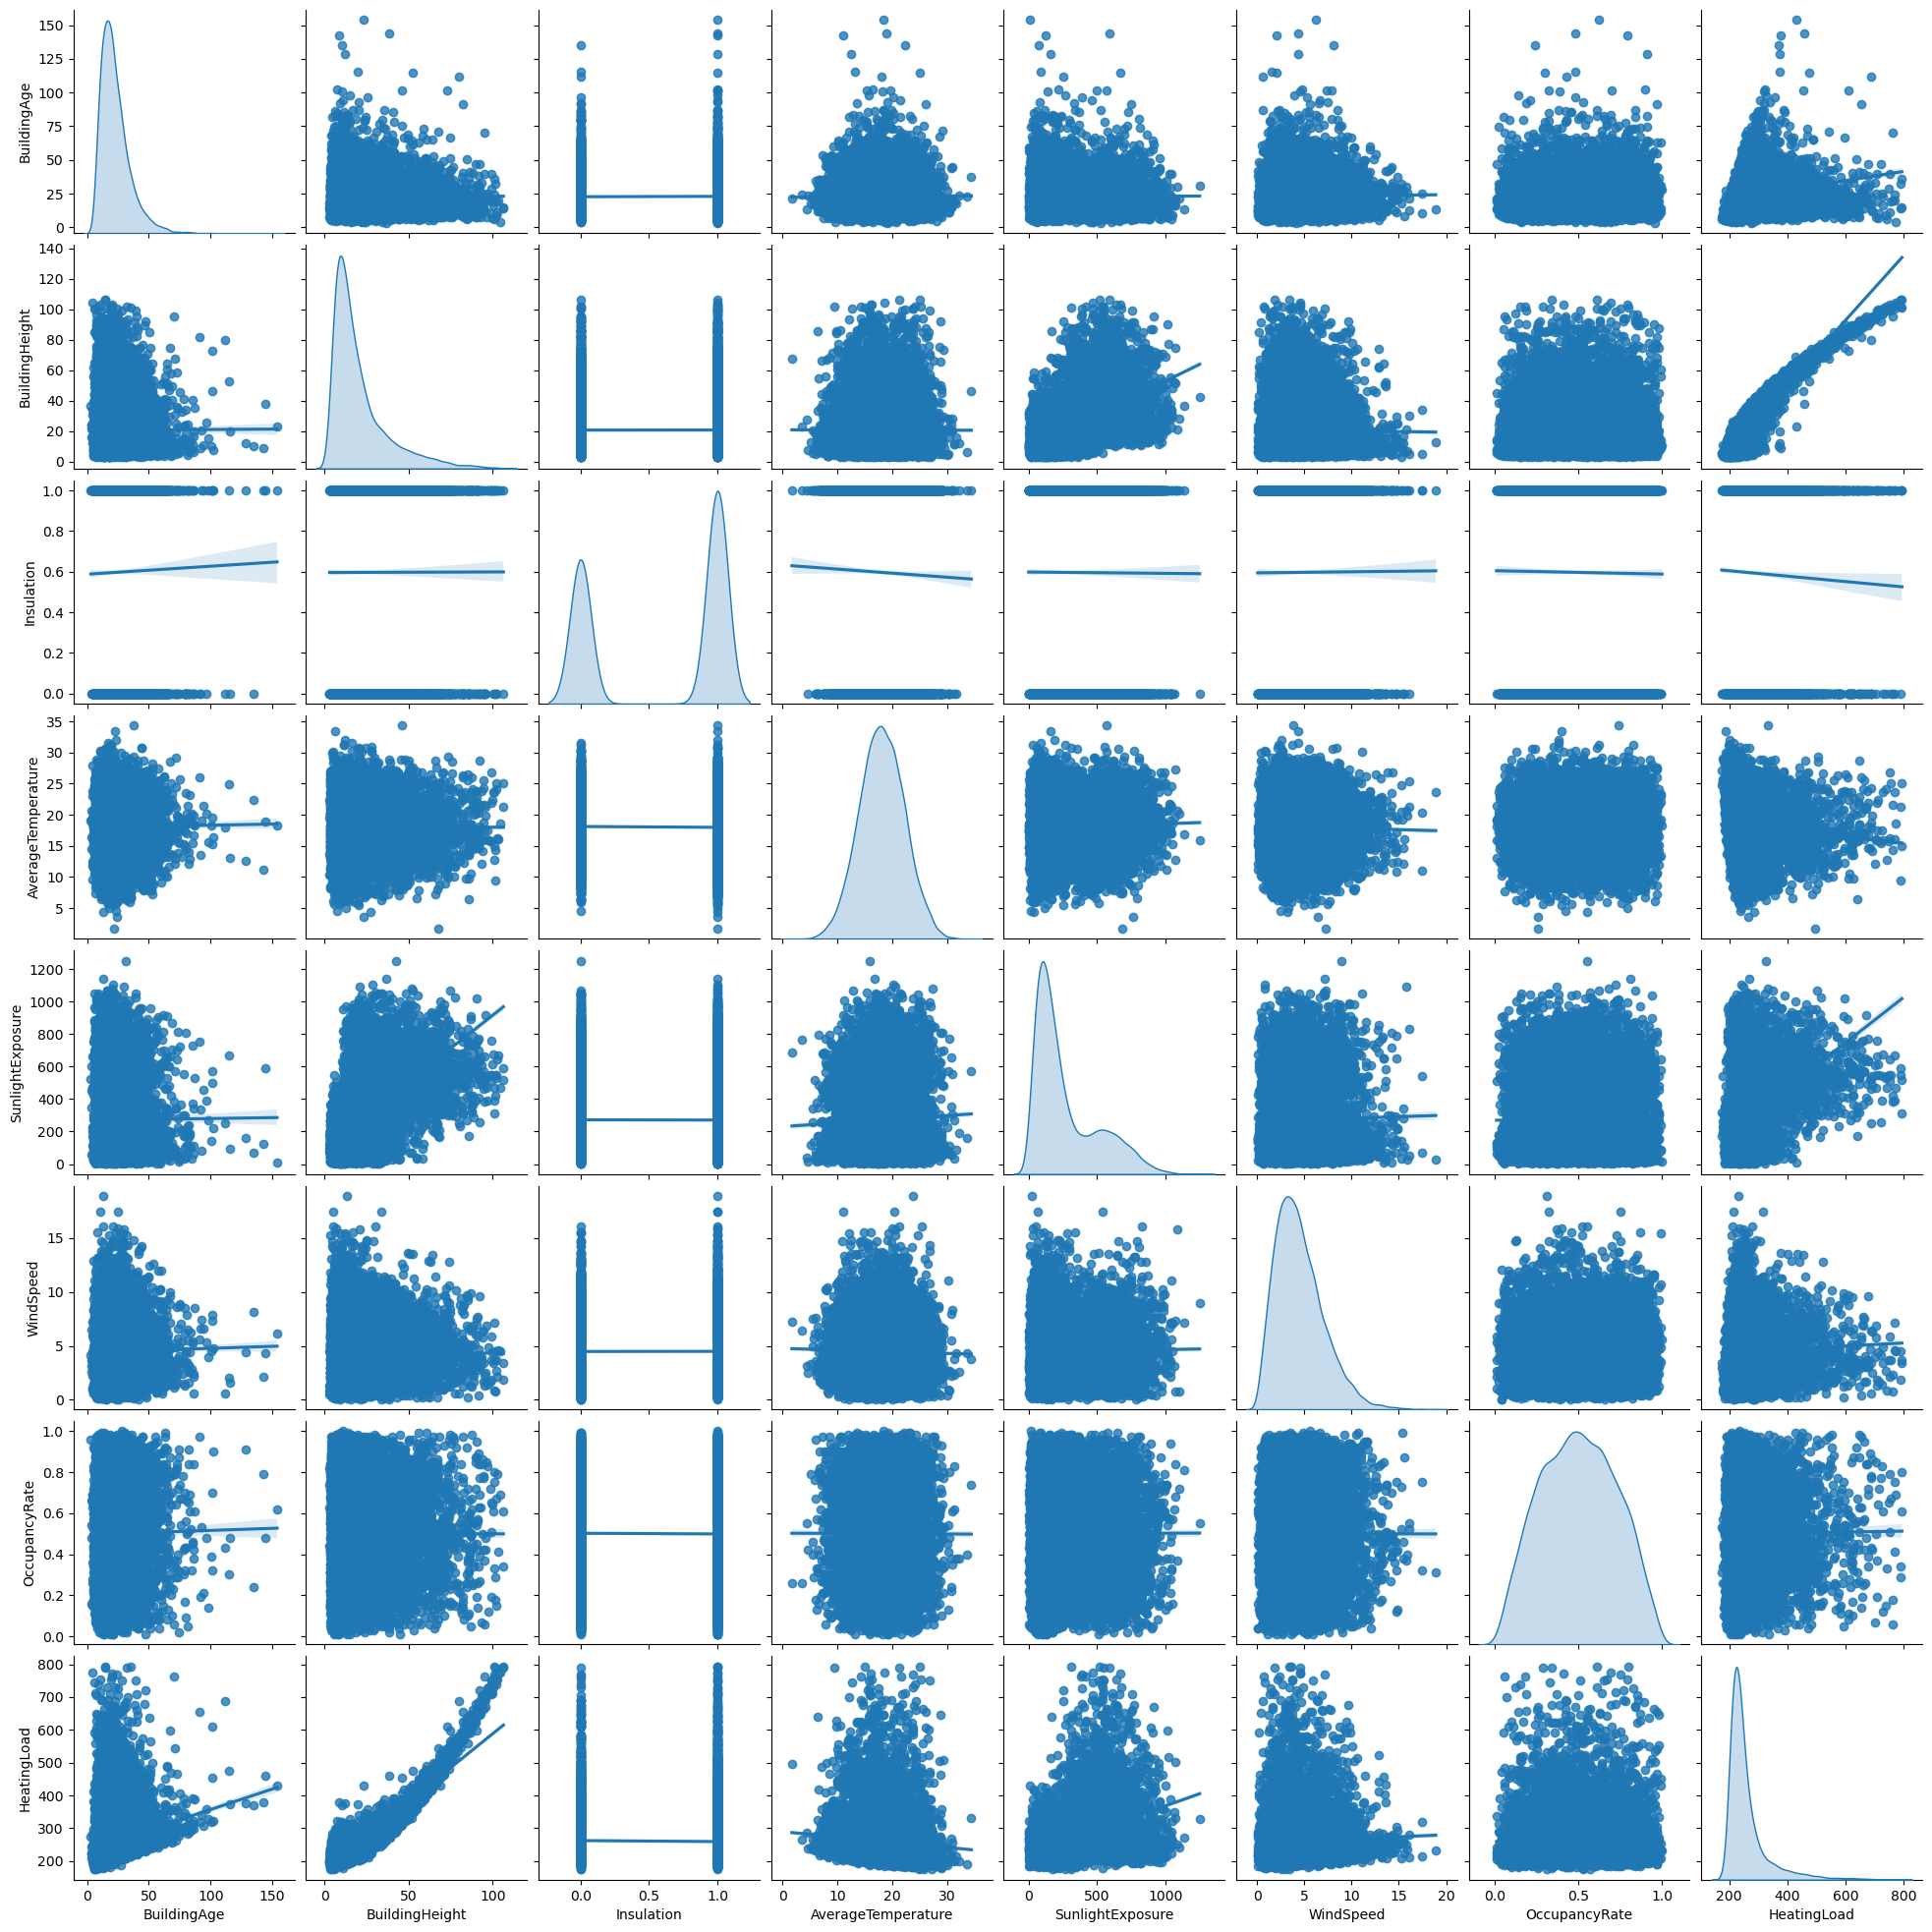

In [11]:
sns.pairplot(heating_load_training_data, kind='reg', diag_kind='kde')

## Checking for Outliers

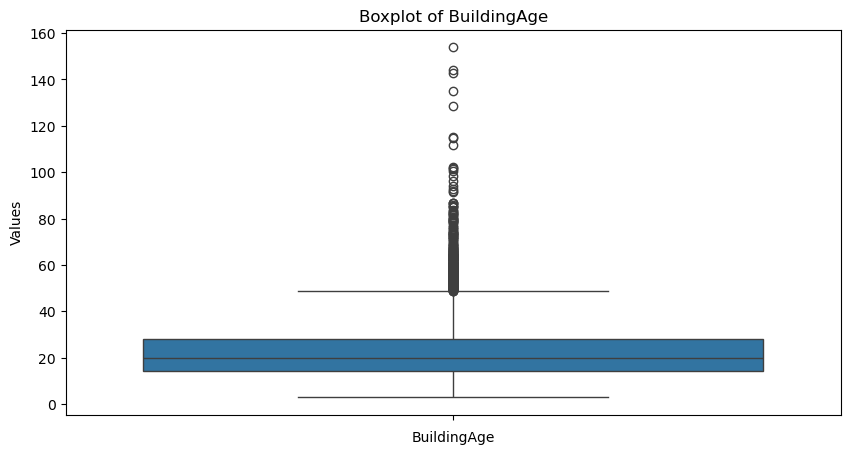

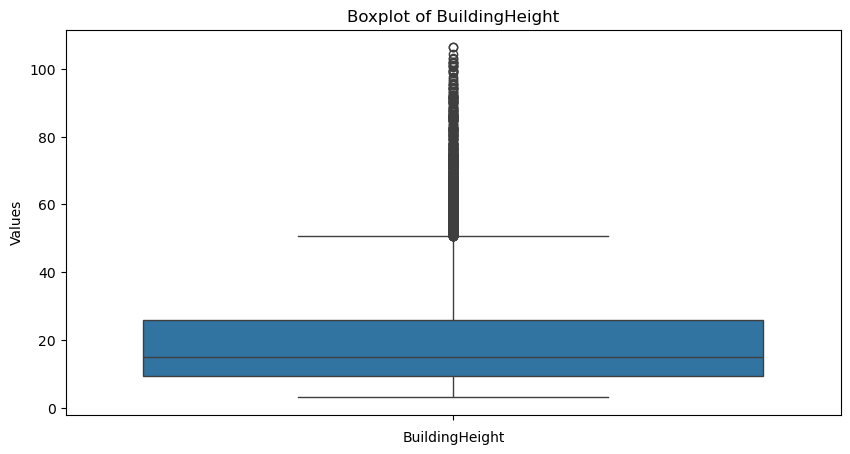

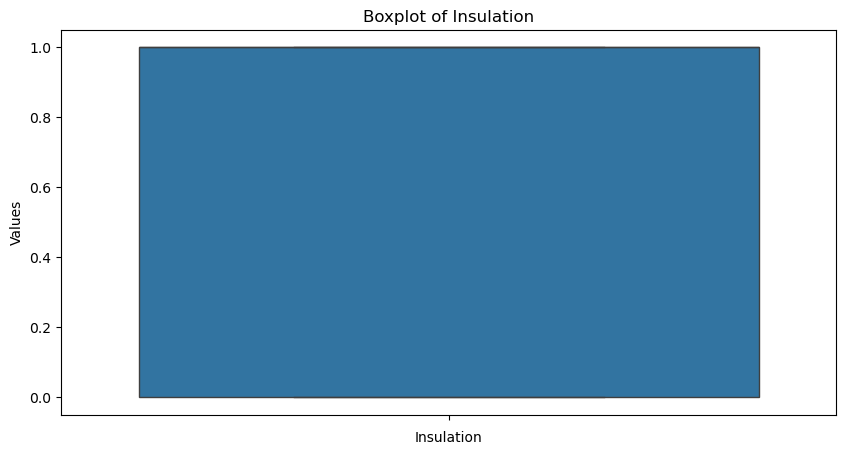

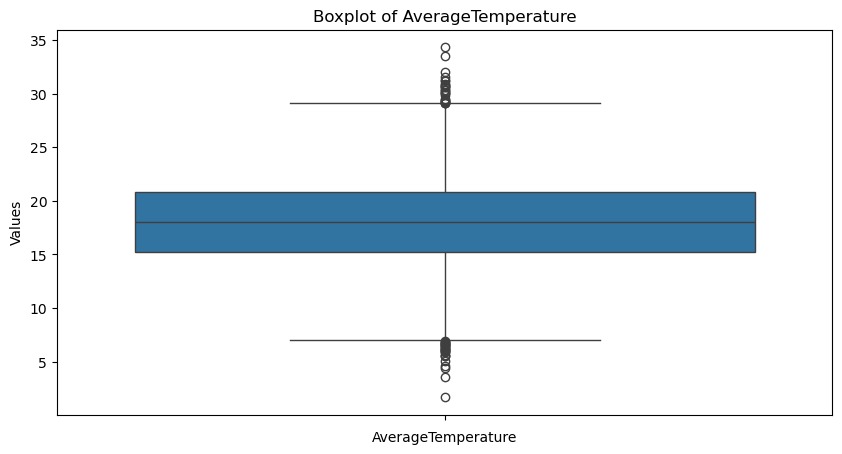

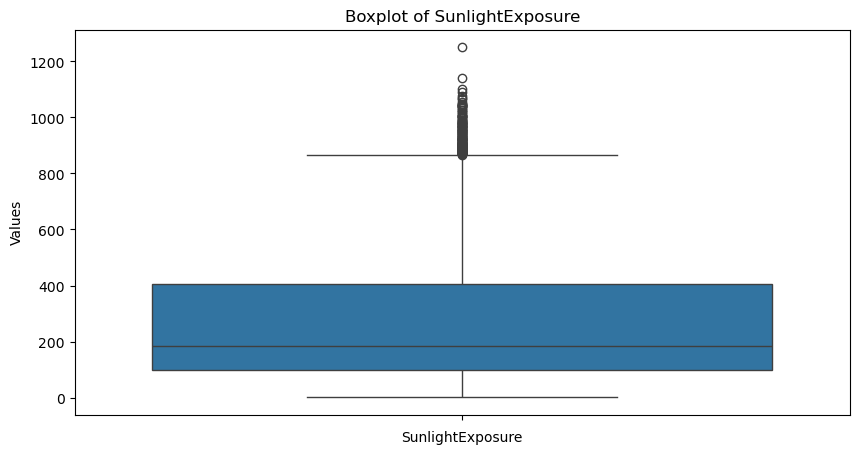

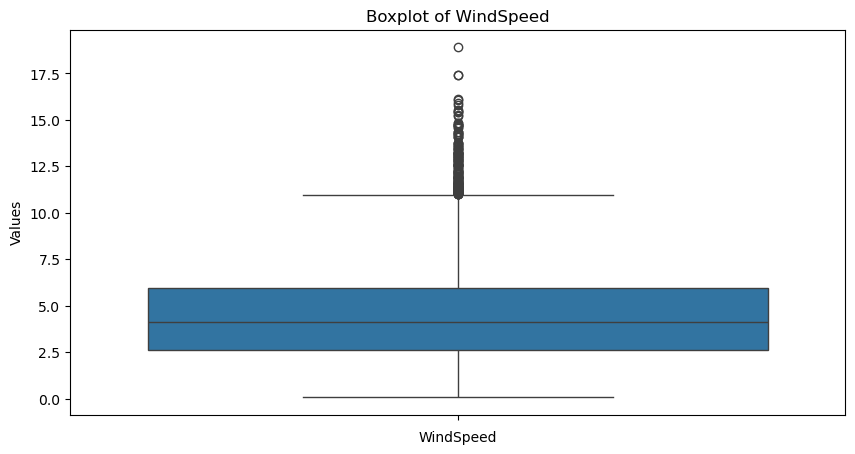

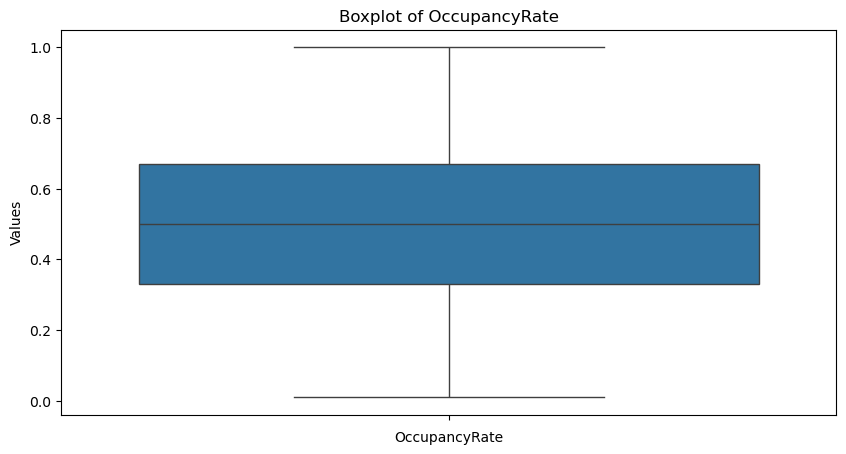

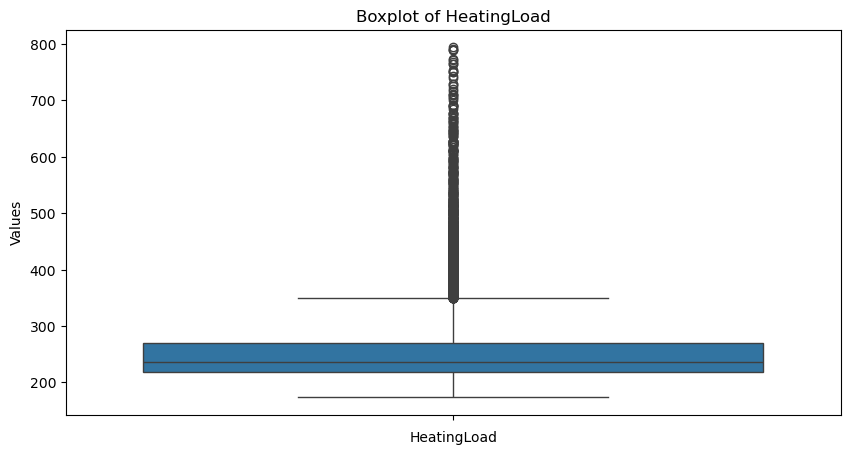

In [12]:
for i in heating_load_training_data.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(heating_load_training_data[i])
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.title(f'Boxplot of {i}')
    plt.show()

## Checking for Normality

### QQ-plot

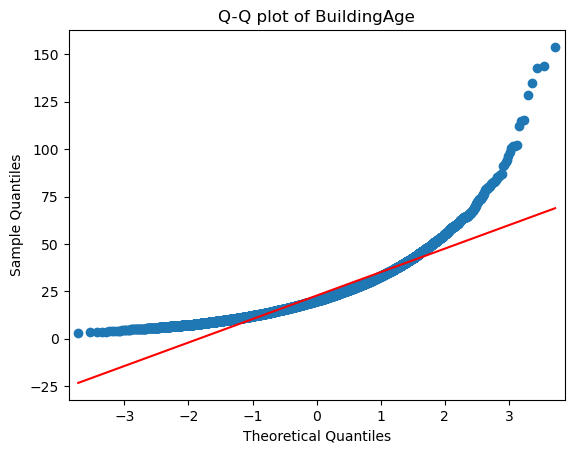

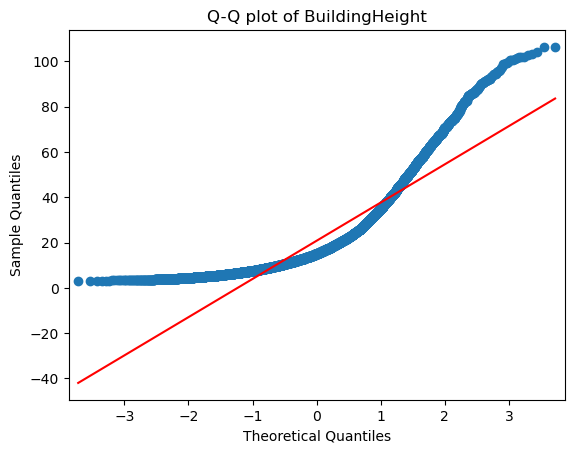

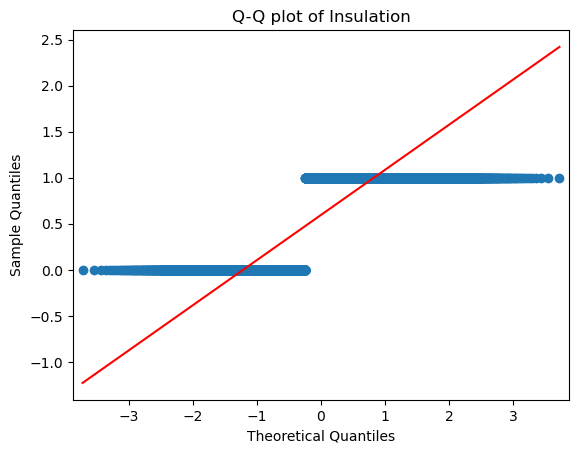

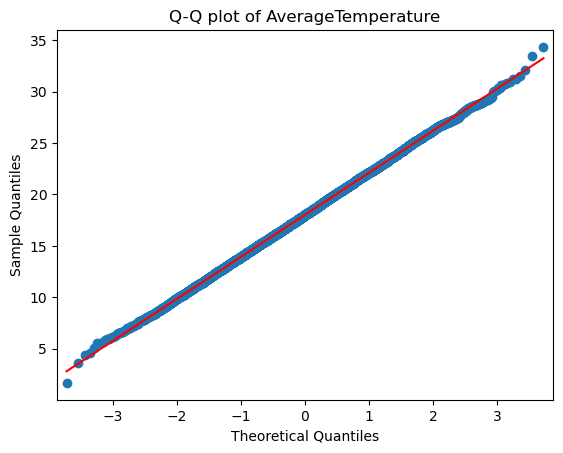

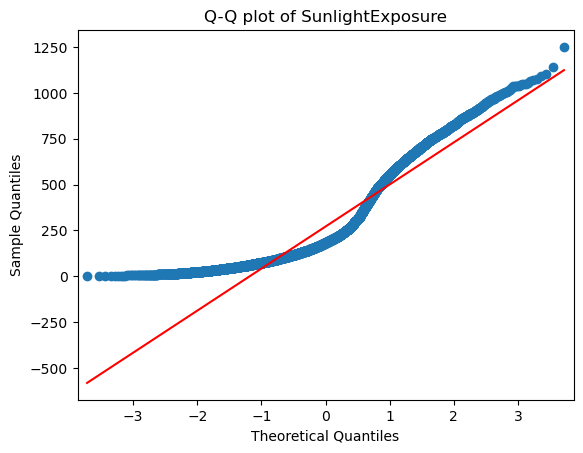

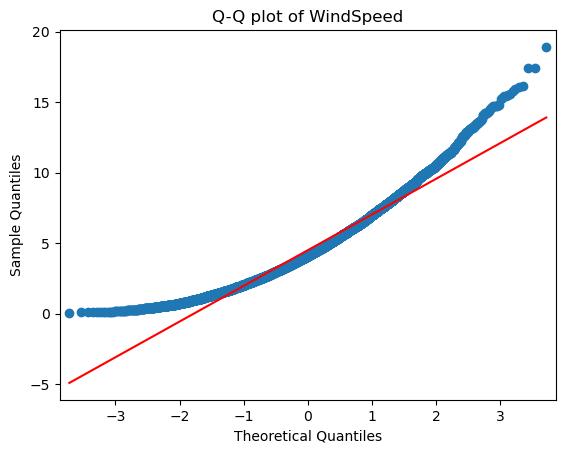

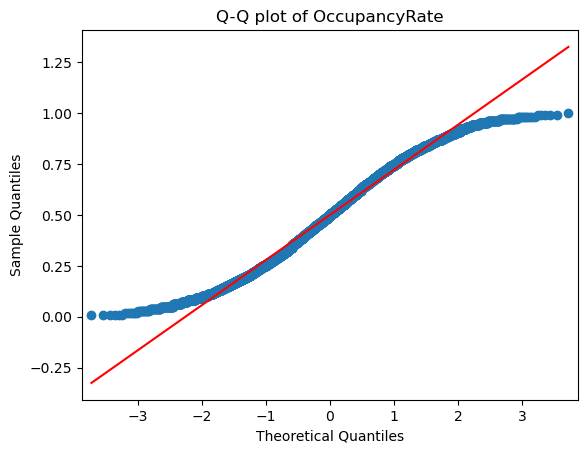

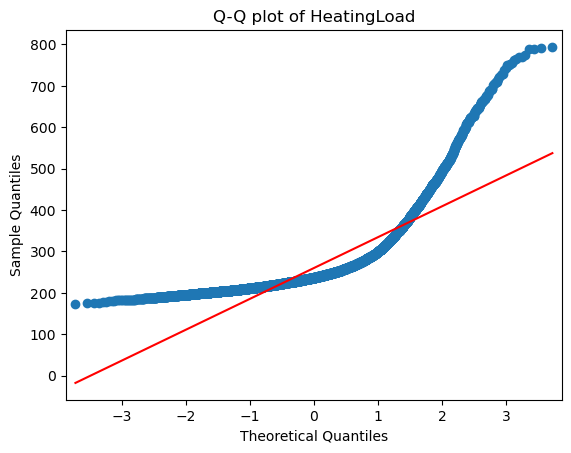

In [14]:
for i in heating_load_training_data.columns:
    sm.qqplot(heating_load_training_data[i], line='s')
    plt.title(f'Q-Q plot of {i}')
    plt.show()

# Correlation Analysis

In [15]:
correlations_heating_load_training_data = heating_load_training_data.corr()

## Correlation Heatmap

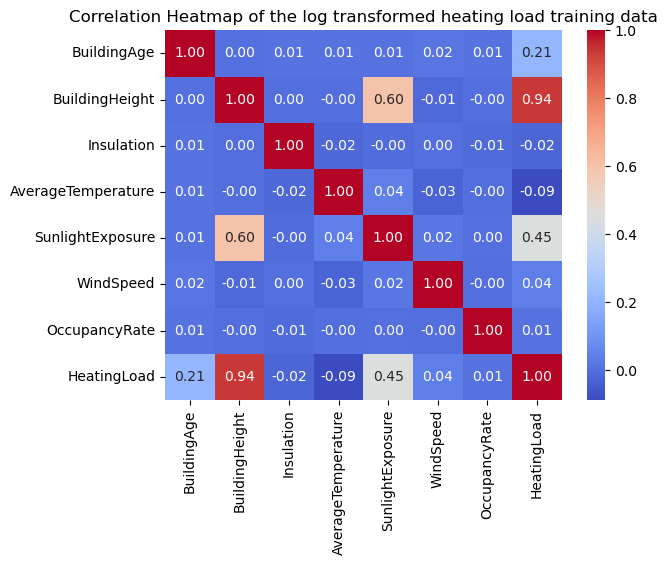

In [16]:
sns.heatmap(correlations_heating_load_training_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of the log transformed heating load training data')
plt.show()

# Model Development

## Full Data training and validation splits

In [17]:
X = heating_load_training_data.drop('HeatingLoad', axis=1)
y = heating_load_training_data['HeatingLoad']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2820)

In [18]:
kfold = KFold(n_splits=10, shuffle=True, random_state=2820)

## Linear Regression

### Forward Feature Selection

In [19]:
linear_regression = LinearRegression()

sfs_linear_regression = SFS(
    linear_regression,
    k_features='best', 
    forward=True, 
    verbose=2, 
    scoring='neg_mean_squared_error', 
    cv=kfold)

sfs_linear_regression.fit(X_train, y_train)


[2024-09-25 17:54:50] Features: 1/7 -- score: -664.5002134607855
[2024-09-25 17:54:50] Features: 2/7 -- score: -435.9953264622712
[2024-09-25 17:54:50] Features: 3/7 -- score: -338.41345121780057
[2024-09-25 17:54:51] Features: 4/7 -- score: -302.0177265136214
[2024-09-25 17:54:51] Features: 5/7 -- score: -284.8701664222082
[2024-09-25 17:54:51] Features: 6/7 -- score: -281.29793261774734
[2024-09-25 17:54:51] Features: 7/7 -- score: -280.9889204882428

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=LinearRegression(), k_features=(1, 7),
                          scoring='neg_mean_squared_error', verbose=2)

In [20]:
# Present metrics for each subset of features
pd.DataFrame.from_dict(sfs_linear_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-626.7461712799578, -677.5720590458773, -609....",-664.500213,"(BuildingHeight,)",22.608446,30.440355,10.146785
2,"(0, 1)","[-435.8120511356286, -436.4522490084913, -369....",-435.995326,"(BuildingAge, BuildingHeight)",18.832386,25.35621,8.45207
3,"(0, 1, 4)","[-342.5529871097752, -341.19814589126094, -289...",-338.413451,"(BuildingAge, BuildingHeight, SunlightExposure)",14.457603,19.465937,6.488646
4,"(0, 1, 3, 4)","[-321.28820095704526, -319.02807934580727, -24...",-302.017727,"(BuildingAge, BuildingHeight, AverageTemperatu...",16.855798,22.694902,7.564967
5,"(0, 1, 3, 4, 5)","[-308.0564921607234, -301.3315431644917, -237....",-284.870166,"(BuildingAge, BuildingHeight, AverageTemperatu...",15.045027,20.256853,6.752284
6,"(0, 1, 2, 3, 4, 5)","[-304.6062401568828, -300.3314830769205, -237....",-281.297933,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.412954,19.405821,6.468607
7,"(0, 1, 2, 3, 4, 5, 6)","[-304.65426867163353, -300.0451960113155, -238...",-280.98892,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.288947,19.238856,6.412952


In [21]:
# Showing the best subset features
print(sfs_linear_regression.k_feature_names_)
print(sfs_linear_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate')
(0, 1, 2, 3, 4, 5, 6)


### Plotting Best Forward Feature Selection Model with Standard Error

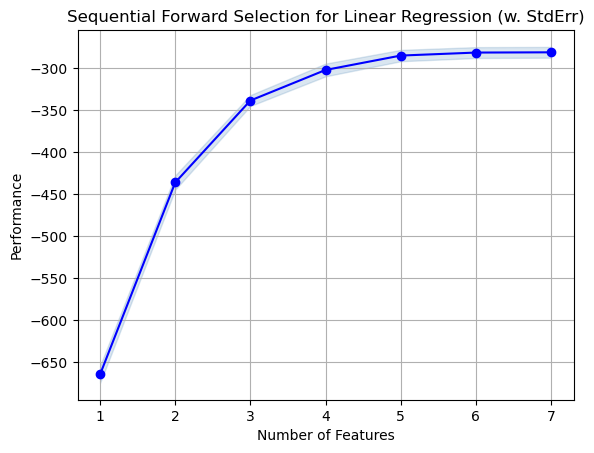

Best number of features: 7
Lowest MSE: -280.9889


In [22]:
plot_sfs(sfs_linear_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for Linear Regression (w. StdErr)')
plt.grid()
plt.show()

print(f'Best number of features: {len(sfs_linear_regression.k_feature_idx_)}')
print(f'Lowest MSE: {np.round(sfs_linear_regression.k_score_, 4)}')

In [23]:
# Select the best subset features for Linear Regression from the original dataset
best_subset_features_linear_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate']]

X_best_subset_features_linear_regression = best_subset_features_linear_regression
y_best_subset_features_linear_regression = y

X_train_best_subset_features_linear_regression, X_val_best_subset_features_linear_regression, y_train_best_subset_features_linear_regression, y_val_best_subset_features_linear_regression = train_test_split(
    X_best_subset_features_linear_regression, y_best_subset_features_linear_regression, test_size=0.2, random_state=2820)

### Multi-Regression Analysis

In [24]:
linear_regression_OLS = sm.OLS(
    y_best_subset_features_linear_regression, X_best_subset_features_linear_regression).fit()
linear_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          9.195e+04
Date:                Wed, 25 Sep 2024   Prob (F-statistic):                        0.00
Time:                        17:54:51   Log-Likelihood:                         -49291.
No. Observations:               10000   AIC:                                  9.860e+04
Df Residuals:                    9993   BIC:                                  9.865e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            1.9053      0.026     73.591      0.000       1.855       1.956
BuildingHeight         4.8863      0.025    199.346      0.000       4.838       4.934
Insulation             8.8661      0.666     13.310      0.000       7.560      10.172
AverageTemperature     3.8115      0.055     69.901      0.000       3.705       3.918
SunlightExposure      -0.0471      0.002    -25.840      0.000      -0.051      -0.044
WindSpeed              5.1935      0.126     41.298      0.000       4.947       5.440
OccupancyRate         51.4702      1.395     36.887      0.000      48.735      54.205
==============================================================================
Omnibus:                       41.429   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.375
Skew:                           0.050   Prob(JB):                     1.56e-12
Kurtosis:                       3.347   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Partial Regression Analysis

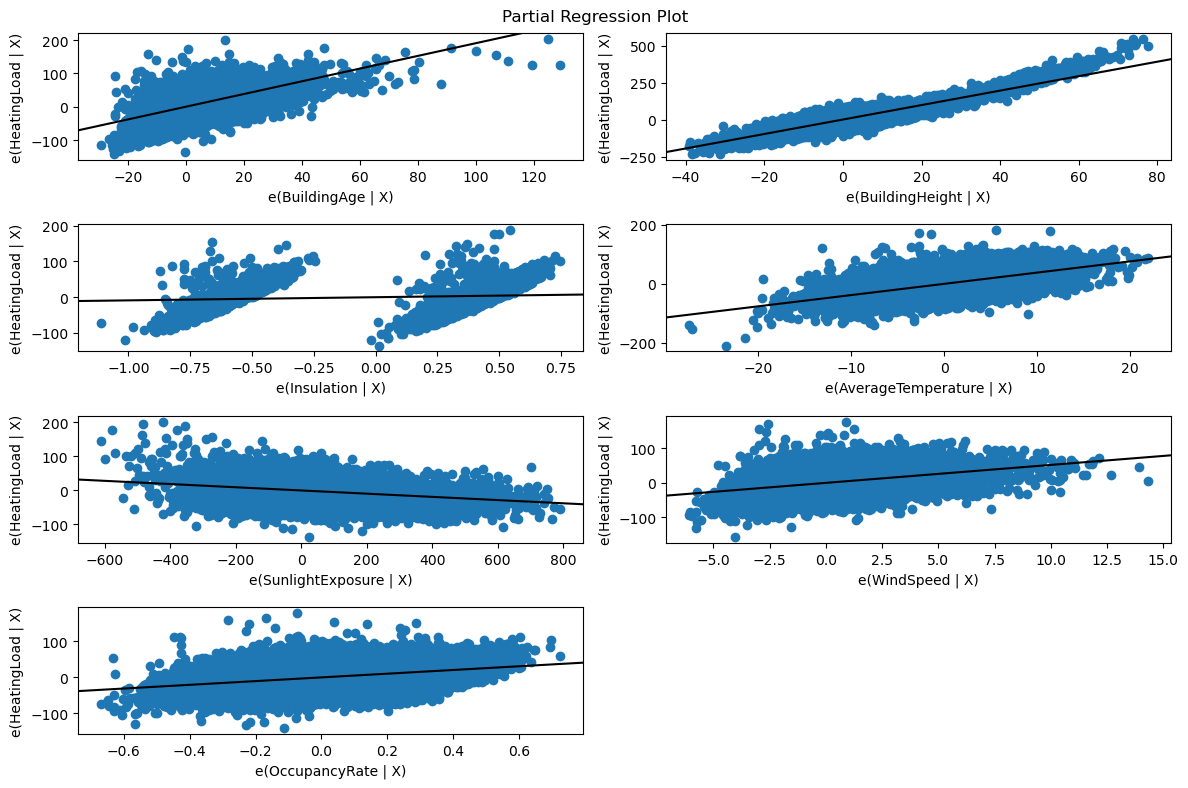

In [25]:
fig_linear_regression_OLS = plt.figure(figsize=(12, 8))
fig_linear_regression_OLS = sm.graphics.plot_partregress_grid(
    linear_regression_OLS, fig=fig_linear_regression_OLS)

### Residual Analysis

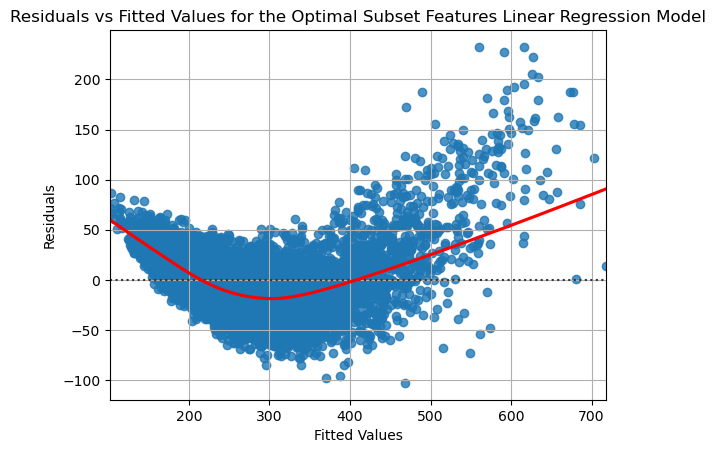

In [26]:
residuals_linear_regression = pd.DataFrame()
residuals_linear_regression['y_hat'] = linear_regression_OLS.fittedvalues
residuals_linear_regression['residuals'] = linear_regression_OLS.resid

sns.residplot(data=residuals_linear_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features Linear Regression Model')
plt.show()

### Making Predictions on Validation Set

In [27]:
optimised_linear_regression = linear_regression.fit(
    X_train_best_subset_features_linear_regression, y_train_best_subset_features_linear_regression)

y_pred_optimised_linear_regression = optimised_linear_regression.predict(
    X_val_best_subset_features_linear_regression)

mse_optimised_linear_regression = mean_squared_error(
    y_val_best_subset_features_linear_regression, y_pred_optimised_linear_regression)

print(f'Validation Mean Squared Error for Linear Regression: {np.round(mse_optimised_linear_regression, 4)}')

Validation Mean Squared Error for Linear Regression: 311.3


## KNN

### Hyperparameter Tuning

In [28]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

param_grid_knn = {
    'kneighborsregressor__n_neighbors': range(1, 21),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2]
}

grid_search_knn = GridSearchCV(
    knn_pipe, param_grid=param_grid_knn, 
    cv=kfold, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1)

grid_search_knn.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__n_neighbors': range(1, 21),
                         'kneighborsregressor__p': [1, 2],
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance']},
             scoring='neg_mean_squared_error')

In [29]:
print(f'Best MSE: {grid_search_knn.best_score_}')
print(f'Best Parameters: {grid_search_knn.best_params_}')

Best MSE: -254.67969239169355
Best Parameters: {'kneighborsregressor__n_neighbors': 6, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}


### Forward Feature Selection

In [30]:
optimised_knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=6, weights='distance', p=2))

sfs_knn_regression = SFS(
    optimised_knn_pipe,
    k_features='best',
    forward=True,
    verbose=2,
    scoring='neg_mean_squared_error',
    cv=kfold)

sfs_knn_regression.fit(X_train, y_train)


[2024-09-25 17:54:59] Features: 1/7 -- score: -500.47861204727315
[2024-09-25 17:54:59] Features: 2/7 -- score: -133.06824584707815
[2024-09-25 17:54:59] Features: 3/7 -- score: -101.6179804839195
[2024-09-25 17:54:59] Features: 4/7 -- score: -103.28556547131033
[2024-09-25 17:54:59] Features: 5/7 -- score: -123.41457615628731
[2024-09-25 17:55:00] Features: 6/7 -- score: -167.31163909019398
[2024-09-25 17:55:00] Features: 7/7 -- score: -254.67969239169355

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('kneighborsregressor',
                                                     KNeighborsRegressor(n_neighbors=6,
                                                                         weights='distance'))]),
                          k_features=(1, 7), scoring='neg_mean_squared_error',
                          verbose=2)

In [31]:
# Present metrics for each subset of features
pd.DataFrame.from_dict(sfs_knn_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-464.29826735933807, -542.5324644169527, -528...",-500.478612,"(BuildingHeight,)",25.337632,34.114972,11.371657
2,"(0, 1)","[-127.50218782258774, -156.59139942892972, -13...",-133.068246,"(BuildingAge, BuildingHeight)",9.916744,13.352055,4.450685
3,"(0, 1, 3)","[-89.84298956619139, -135.84703286239306, -76....",-101.61798,"(BuildingAge, BuildingHeight, AverageTemperature)",13.697581,18.442631,6.147544
4,"(0, 1, 3, 4)","[-101.29472159504229, -129.60884185907264, -74...",-103.285565,"(BuildingAge, BuildingHeight, AverageTemperatu...",13.080269,17.611473,5.870491
5,"(0, 1, 3, 4, 5)","[-109.5872832053849, -147.6995861412446, -96.7...",-123.414576,"(BuildingAge, BuildingHeight, AverageTemperatu...",14.62696,19.693961,6.564654
6,"(0, 1, 2, 3, 4, 5)","[-162.65737881475195, -213.47718165449834, -11...",-167.311639,"(BuildingAge, BuildingHeight, Insulation, Aver...",20.024649,26.961492,8.987164
7,"(0, 1, 2, 3, 4, 5, 6)","[-230.20593665536558, -311.00084004127365, -20...",-254.679692,"(BuildingAge, BuildingHeight, Insulation, Aver...",27.903439,37.569614,12.523205


In [32]:
# Showing the best subset features
print(sfs_knn_regression.k_feature_names_)
print(sfs_knn_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'AverageTemperature')
(0, 1, 3)


### Plotting Best Forward Feature Selection Model with Standard Error

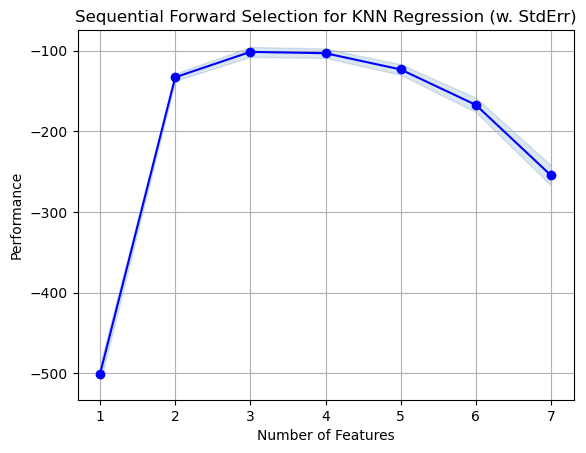

Best number of features: 3
Lowest MSE: -101.618


In [33]:
plot_sfs(sfs_knn_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for KNN Regression (w. StdErr)')
plt.grid()
plt.show()

print(f'Best number of features: {len(sfs_knn_regression.k_feature_idx_)}')
print(f'Lowest MSE: {np.round(sfs_knn_regression.k_score_, 4)}')

In [34]:
# Select the best subset features for KNN Regression from the original dataset
best_subset_features_knn_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'AverageTemperature']]

X_best_subset_features_knn_regression = best_subset_features_knn_regression
y_best_subset_features_knn_regression = y

X_train_best_subset_features_knn_regression, X_val_best_subset_features_knn_regression, y_train_best_subset_features_knn_regression, y_val_best_subset_features_knn_regression = train_test_split(
    X_best_subset_features_knn_regression, y_best_subset_features_knn_regression, test_size=0.2, random_state=2820)

### Multi-Regression Analysis

In [35]:
knn_regression_OLS = sm.OLS(
    y_best_subset_features_knn_regression, X_best_subset_features_knn_regression).fit()
knn_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          1.475e+05
Date:                Wed, 25 Sep 2024   Prob (F-statistic):                        0.00
Time:                        17:55:00   Log-Likelihood:                         -51132.
No. Observations:               10000   AIC:                                  1.023e+05
Df Residuals:                    9997   BIC:                                  1.023e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            2.2394      0.030     73.782      0.000       2.180       2.299
BuildingHeight         4.6457      0.023    201.172      0.000       4.600       4.691
AverageTemperature     5.8557      0.048    123.131      0.000       5.762       5.949
==============================================================================
Omnibus:                       26.667   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.424
Skew:                          -0.085   Prob(JB):                     4.08e-07
Kurtosis:                       3.205   Cond. No.                         5.09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Partial Regression Analysis

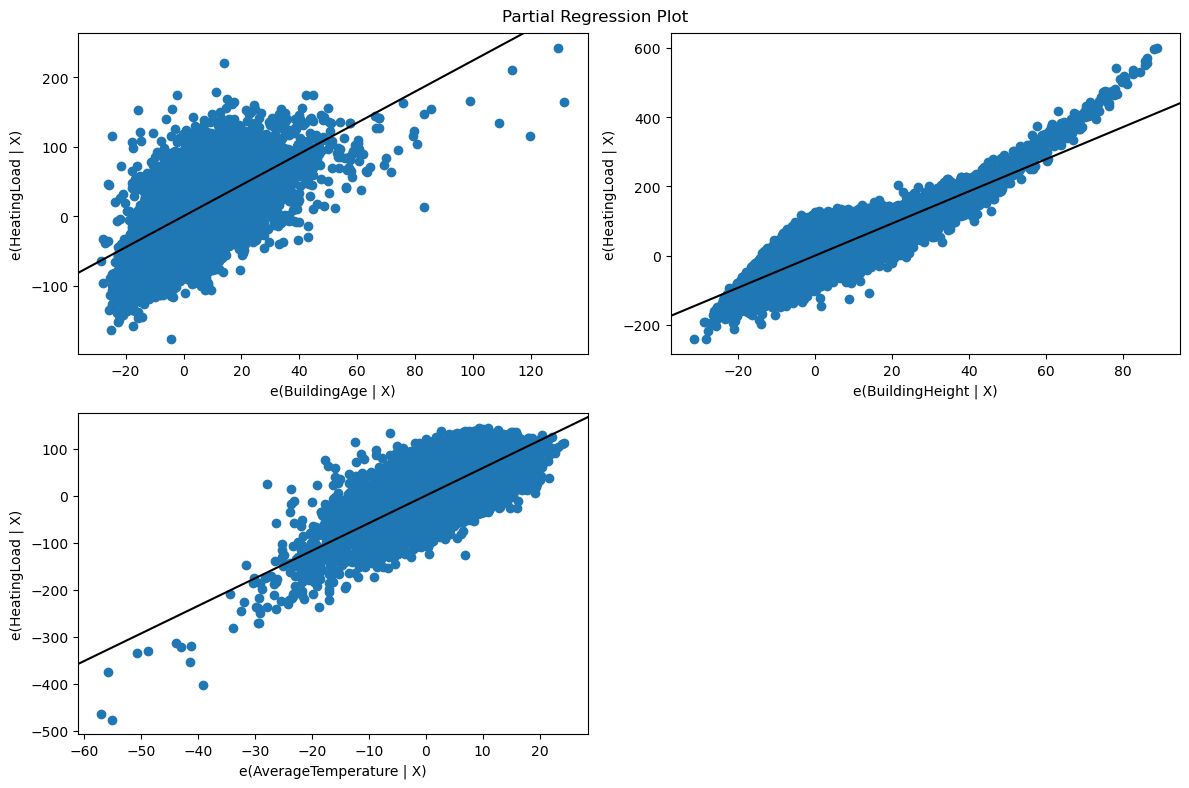

In [36]:
fig_knn_regression_OLS = plt.figure(figsize=(12, 8))
fig_knn_regression_OLS = sm.graphics.plot_partregress_grid(
    knn_regression_OLS, fig=fig_knn_regression_OLS)

### Residual Analysis

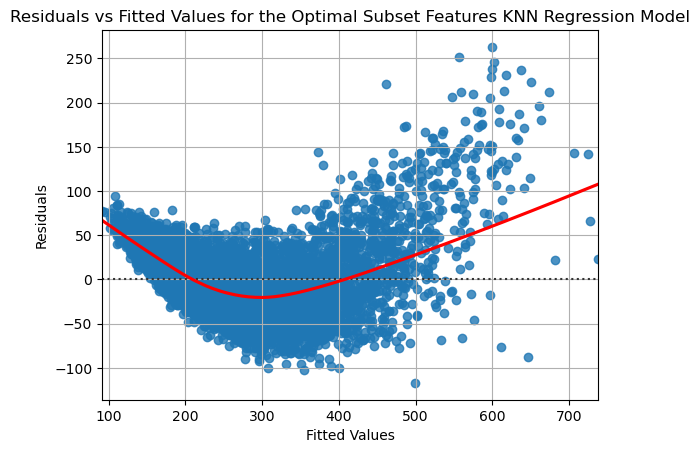

In [37]:
residuals_knn_regression = pd.DataFrame()
residuals_knn_regression['y_hat'] = knn_regression_OLS.fittedvalues
residuals_knn_regression['residuals'] = knn_regression_OLS.resid

sns.residplot(data=residuals_knn_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features KNN Regression Model')
plt.show()

### Making Predictions on Validation Set

In [38]:
optimised_knn_regression = optimised_knn_pipe.fit(
    X_train_best_subset_features_knn_regression, y_train_best_subset_features_knn_regression)

y_pred_optimised_knn_regression = optimised_knn_regression.predict(
    X_val_best_subset_features_knn_regression)

mse_optimised_knn_regression = mean_squared_error(
    y_val_best_subset_features_knn_regression, y_pred_optimised_knn_regression)

print(f'Validation Mean Squared Error for KNN Regression: {np.round(mse_optimised_knn_regression, 4)}')

Validation Mean Squared Error for KNN Regression: 88.8736


# Comparing MSE Score

In [52]:
# Compare the performance of the two models
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regression'],
    'Validation MSE': [mse_optimised_linear_regression, mse_optimised_knn_regression]
})

model_comparison['Validation MSE'] = model_comparison['Validation MSE'].apply(lambda x: np.round(x, 4))

model_comparison.sort_values('Validation MSE')

,Model,Validation MSE
1,KNN Regression,88.8736
0,Linear Regression,311.3000


# Saving Predictions of Best Regression Model on Test Dataset

In [40]:
# Get the optimal features for the KNN Regression model
optimal_features_knn_regression = heating_load_test_without_HL_data[[
    'BuildingAge', 'BuildingHeight', 'AverageTemperature']]

y_pred_optimal_features_knn_regression = np.round(optimised_knn_regression.predict(optimal_features_knn_regression), 4)

# Create a dataframe for Heating Load predictions
heating_load_test_without_HL_data_predictions = pd.DataFrame()
heating_load_test_without_HL_data_predictions['HeatingLoad'] = y_pred_optimal_features_knn_regression

predictions = heating_load_test_without_HL_data_predictions.to_csv(
    '510575452_Assignment_HL_prediction.csv')

heating_load_test_without_HL_data_predictions

,HeatingLoad
0,233.4642
1,203.9477
2,312.3496
3,243.6622
4,202.0533
...,...
4939,199.4732
4940,276.4541
4941,277.3816
4942,271.4229


# Code Chunk To Run Tests on my Predictions

In [ ]:
HeatingLoad_test = pd.read_csv("HeatingLoad_test.csv")

test_error = mean_squared_error(HeatingLoad_test['HeatingLoad'], heating_load_test_without_HL_data_predictions)

print(test_error)